# Setup

In [ ]:
# 결측치 검사
train_data.isna().any().any()

이미지 불러올 때, 드라이브에 압축한 파일을 올려서 그때그때 읽어오는 방법 및 드라이브에 사진 모두 올려놓고 읽어오는 방법은 훨씬 느리다! 세션 연결 후, 할당받은 세션에 이미지 파일 압축을 풀어서 하나씩 불러오는 방법이 제일 빠르다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 압축 파일으을 '/content'로 복사
import shutil
shutil.copy('/content/drive/MyDrive/COSE474/PROJECT/data/train_images.zip', '/content/')

# unzip으로 압축 풀기 (할당받은 세션에 압축 풀기)
import zipfile
with zipfile.ZipFile('/content/train_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/product_images/')

# 현재 경로 지정
# %cd '/content/drive/MyDrive/COSE474/PROJECT'

Mounted at /content/drive


In [ ]:
%ls

drive/  product_images/  sample_data/  train_images.zip


필요한 라이브러리 설치

In [ ]:
! pip install openai-clip
! pip install faiss-gpu

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import re

import clip
from clip.simple_tokenizer import SimpleTokenizer

import faiss
import matplotlib.pyplot as plt

from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt

%matplotlib inline

# Load model

이미지, 텍스트 임베딩 사이즈는 모두 512이다.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

embed_dim = model.text_projection.shape[1]

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 23.9MiB/s]


In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

# Utils

In [ ]:
tokenizer = clip.tokenize

In [ ]:
# 이동 평균, 연속된 데이터의 평균을 구함
class RollingMean():
    def __init__(self):
        self.n = 0
        self.mean = 0

    def update(self, value):
        self.mean = (self.mean * self.n + value) / (self.n+1)
        self.n += 1

    def result(self):
        return self.mean

# Sampler and dataset
모든 배치에 동일한 그룹의 두 샘플이 항상 존재하는지 확인하는 샘플러를 구현한다.

이는 Triplet SemiHardLoss를 사용하기 위해서 중요하다.

구현 출처: https://github.com/alfonmedela/triplet-loss-pytorch



In [ ]:
class SameGroupSampler(Sampler):
    ''' 라벨 그룹 내에서 두개의 샘플을 추출하여, 데이터셋에서 해당 인덱스를 반환하는 샘플러 '''
    def __init__(self, df ,ds):
        super().__init__(ds)

        # 딕셔너리를 생성하여, posting_id와 데이터셋 내 인덱스를 mapping
        self.index_to_position = dict(zip(df.index, range(len(df))))

        # label_group은 label_group을 기준으로 posting_id를 묶는다.
        # 각 그룹 내에서 정렬된 배열로 만든다.
        self.label_group = df.reset_index().groupby('label_group')['posting_id'].apply(set).map(sorted).map(np.array)

    def __len__(self):
        # 샘플러의 총 길이 반환 (label_group의 수)
        return len(self.label_group)

    def __iter__(self):
        for _ in range(len(self)):
            # label_group 내에서 무작위로 하나의 그룹을 선택
            label_group_sample = self.label_group.sample(1).iloc[0]

            # 해당 그룹에서 두개의 posting_id를 선택
            # 해당 인덱스를 yield 함 (iterate)
            sample1, sample2 = np.random.choice(label_group_sample, 2, replace=False)

            yield self.index_to_position[sample1]
            yield self.index_to_position[sample2]

In [ ]:
class MyDataset(Dataset):
    ''' 데이터셋 정의 '''
    def __init__(self, data, images_path):
        super().__init__()
        self.data = data
        self.images_path = images_path
        self.has_target = ('label_group' in data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = f'{self.images_path}/{row["image"]}' ##
        image = preprocess(Image.open(image_path))
        text = tokenize([row['title']])[0]

        if self.has_target:
            return image, text, row['label_group']
        else:
            return image, text, 0

In [ ]:
# Load train data
train_images_path = Path('product_images')

train_data = pd.read_csv('/content/drive/MyDrive/COSE474/PROJECT/data/train.csv', index_col='posting_id')

dstrain = MyDataset(train_data, train_images_path)

# batch size 조절하기 ! (RAM 터짐 주의)
dltrain = DataLoader(dstrain, batch_size=128, sampler=SameGroupSampler(train_data, dstrain))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [ ]:
len(dstrain), len(dltrain)

(34250, 87)

In [ ]:
next(iter(dltrain))

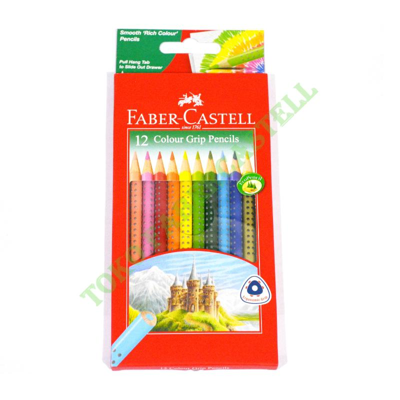

In [ ]:
file_name = train_data.iloc[425]['image']
path = f'product_images/{file_name}'
img = Image.open(path)

display(img.resize((400,400)))

# 그냥 이미지 읽어오는게 더 빠른지, 압축한 파일에서 그때그때 읽어오는게 빠른지 잘 모르겠다...
# 전자가 훨씬 빠를거라고 생각해서 바꿨는데 가끔씩 로딩하는데 생각보다 너무 오래 걸림! (빠를때는 또 빠르다)
# ----->** 세션에서 압축 풀어서 하니까 불러오는 속도가 훨씬 빠르다! **

#Triplet Loss
- 세개의 샘플 (앵커, 양성, 부정)을 학습에 이용함
- 구성 요소
    - 앵커: 학습 중인 모델에 의해 임베딩된 특정 샘플
    - 양성: 앵커와 동일한 클래스, 또는 비슷한 클래스의 다른 샘플
    - 부정: 앵커와 다른 클래스에 속하는 샘플
- 목표: 앵커와 양성 샘플 간의 거리를 최소화하고, 앵커와 부정 샘플 간의 거리를 최대화하여 임베딩 공간에서 클래스 간의 경계를 명확하게 만드는 것

Contrastive Loss와의 차이점
- Triplet Loss는 세 개의 샘플을 사용하여 학습하며, 주로 Hard Sample Mining 기술과 함께 사용된다.
- Contrastive Loss는 두개의 샘플을 사용해 학습한다. 두개의 쌍을 선택한다.  

  

구현 함수 출처: https://github.com/alfonmedela/triplet-loss-pytorch/tree/master'''


In [ ]:
def pairwise_distance_torch(embeddings, device):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      embeddings: 2-D Tensor of size [number of data, feature dimension].
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, device, margin=1.0):
    """Computes the triplet loss_functions with semi-hard negative mining.
       The loss_functions encourages the positive distances (between a pair of embeddings
       with the same labels) to be smaller than the minimum negative distance
       among which are at least greater than the positive distance plus the
       margin constant (called semi-hard negative) in the mini-batch.
       If no such negative exists, uses the largest negative distance instead.
       See: https://arxiv.org/abs/1503.03832.
       We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
       [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
       2-D float `Tensor` of l2 normalized embedding vectors.
       Args:
         margin: Float, margin term in the loss_functions definition. Default value is 1.0.
         name: Optional name for the op.
       """

    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return TripletSemiHardLoss(target, input, self.device)

# Train

In [ ]:
# hyperparameter
n_epochs = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-2, total_steps=n_epochs * (2*len(dltrain)-1)))
criterion = TripletLoss(device)

In [ ]:
loss_means = []

for epoch in range(n_epochs):
    with tqdm(total=2*len(dltrain)-1) as bar:
        loss_mean = RollingMean()
        for images, texts, targets in dltrain:
            targets = targets.to(device)

            # encoding 과정
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))

            optim.zero_grad()

            features = torch.hstack([images_features, texts_features])

            # L2-normalize features
            features = features / features.norm(2, dim=1, keepdim=True)

            # Apply Triplet SemiHardLoss
            loss = criterion(features, targets)

            loss.backward()
            optim.step()
            scheduler.step()

            loss_mean.update(loss.item())
            bar.update()
            bar.set_description('{:.4f}'.format(loss_mean.result()))
            loss_means.append(loss_mean.result())

0.1063: 100%|██████████| 173/173 [02:03<00:00,  1.40it/s]


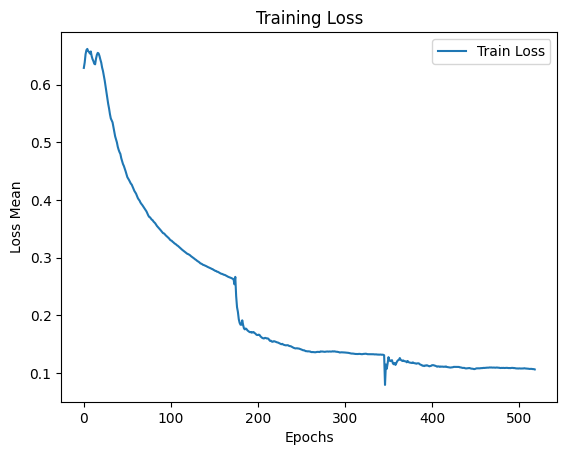

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss_mean values
plt.plot(loss_means, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Mean')
plt.title('Training Loss')
plt.legend()
plt.show()

# Run on train

In [ ]:
saved_features = find_similarities_and_indexes(df_train, train_images_path)

100%|██████████| 1071/1071 [03:18<00:00,  5.38it/s]


In [ ]:
def find_similarities_and_indexes(data, images_path, top_n=20):
    # Create pytorch Dataset/DataLoader
    dataset = MyDataset(data, images_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    features = np.empty((len(data), 2*512), dtype=np.float32)

    i = 0
    for images, texts, targets in tqdm(dataloader):
        n = len(images)
        with torch.no_grad():
            # Generate image and text features
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))

        # Concat features (first images then texts)
        features[i:i+n, :512] = images_features.cpu()
        features[i:i+n, 512:] = texts_features.cpu()
        i += n

    features /= np.linalg.norm(features, 2, axis=1, keepdims=True)
    index = faiss.IndexFlatIP(2*512)
    index.add(features)
    return index.search(features, top_n)

# Inference on train data

In [ ]:
similarities, indexes = find_similarities_and_indexes(df_train, train_images_path, top_n=6, features_file='features.npy')

100%|██████████| 1071/1071 [03:10<00:00,  5.63it/s]


In [ ]:
# Convert index to groups
found_groups = df_train['label_group'].values[indexes]

In [ ]:
# Check if matches are from same group
is_same_group = (found_groups == df_train['label_group'].values[:, np.newaxis])

In [ ]:
def plot_from_index(data, indices):
    images = []
    for index in indices:
        file_name = data.iloc[index]['image']
        path = f'product_images/{file_name}'
        img = Image.open(path)
        images.append(img.resize((400, 400)))

    # 그리드로 이미지 배열
    rows = 1  # 원하는 행 수
    cols = len(indices) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

    for i, img in enumerate(images):
        # ax = axes[i // cols, i % cols] if len(indices) > 1 else axes
        axes[i].imshow(img)
        axes[i].axis('off')  # 이미지 축 제거

        if i == 0:  # 첫 번째 이미지에 테두리 추가

            img_width, img_height = img.size
            rect = plt.Rectangle(((img_width - 400) // 2, (img_height - 400) // 2), 400, 400, linewidth=5, edgecolor='blue', facecolor='none')  # 테두리 설정
            axes[i].add_patch(rect)  # 이미지에 테두리 추가

    plt.tight_layout()
    plt.show()

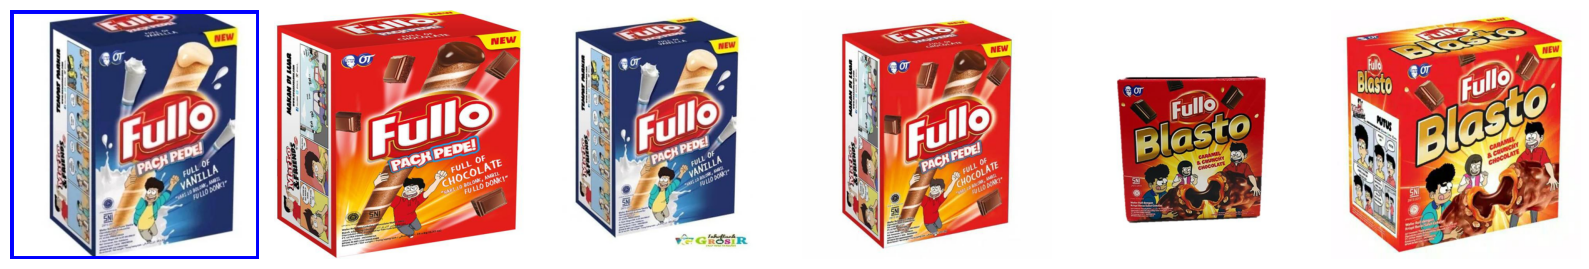

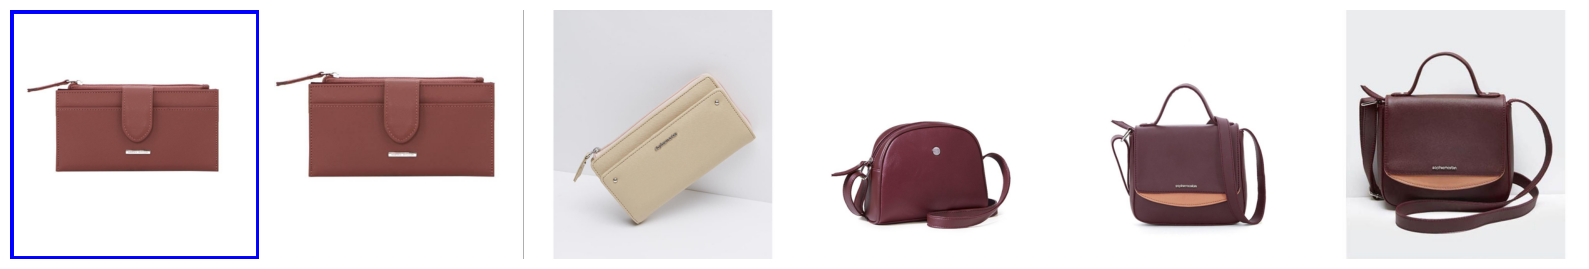

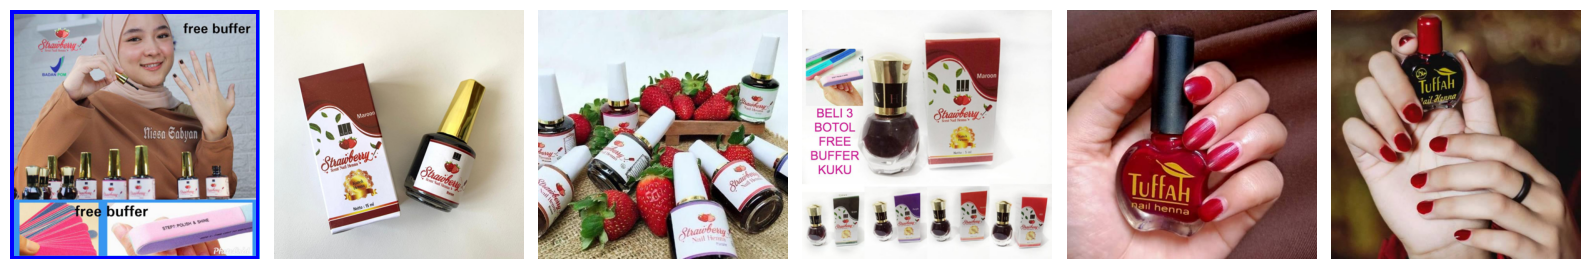

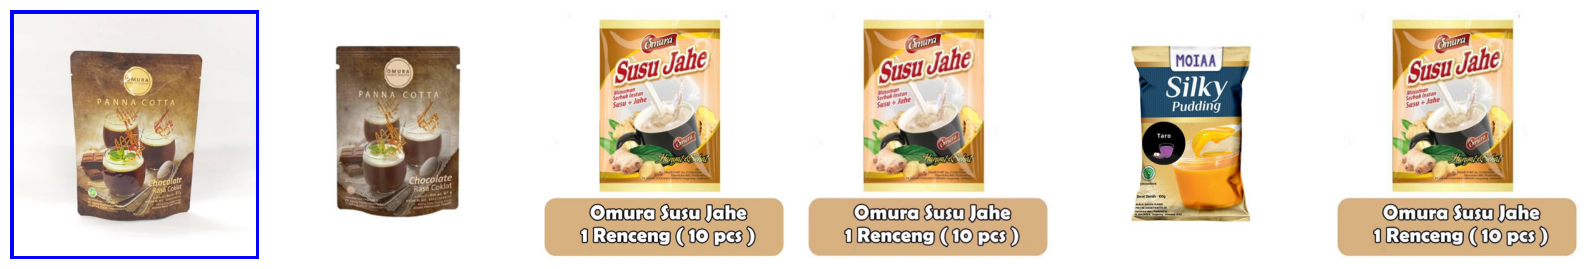

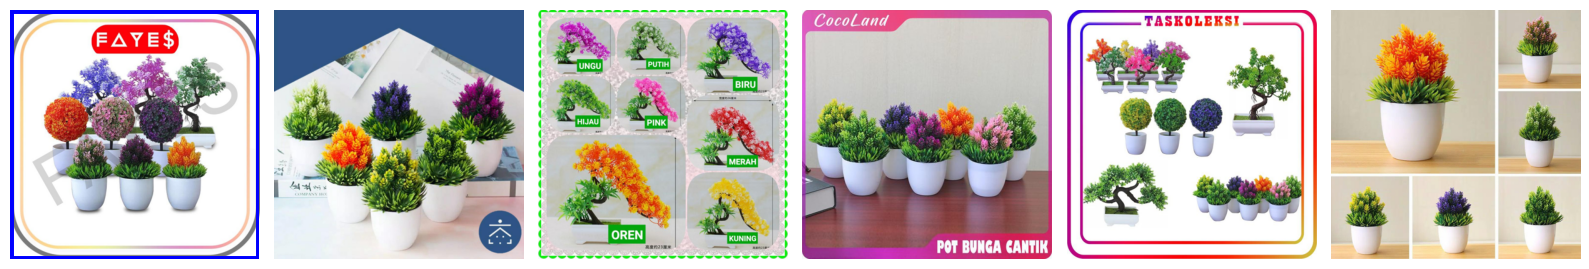

In [ ]:
plot_from_index(train_data, indexes[4009][:6])
plot_from_index(train_data, indexes[6000][:6])
plot_from_index(train_data, indexes[10009][:6])
plot_from_index(train_data, indexes[23413][:6])
plot_from_index(train_data, indexes[1045][:6])

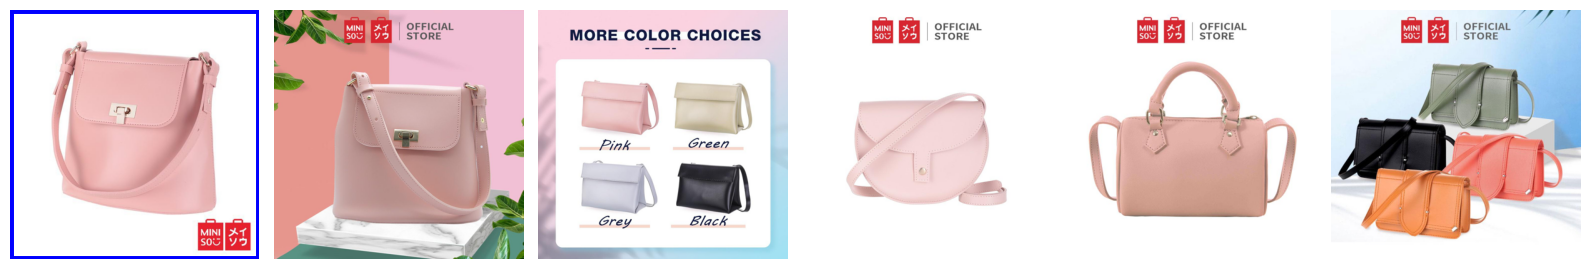

In [ ]:
plot_from_index(train_data, indexes[6000][:6])

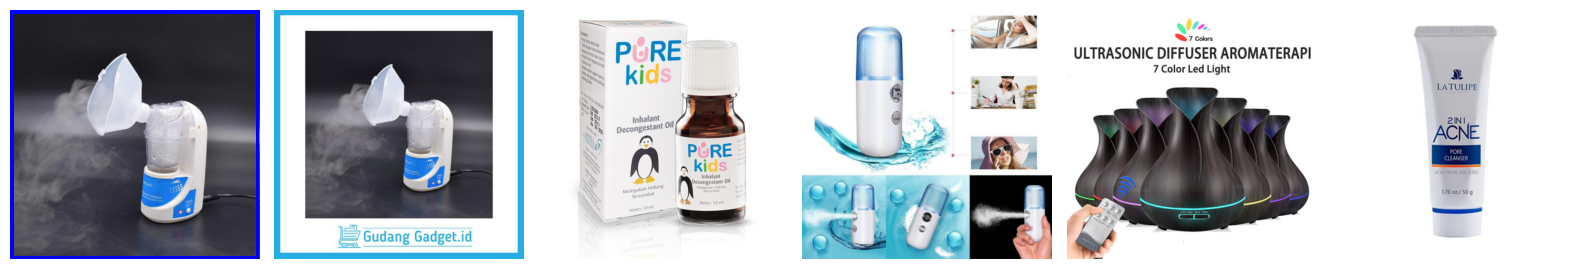

In [ ]:
plot_from_index(train_data, indexes[23412][:6])

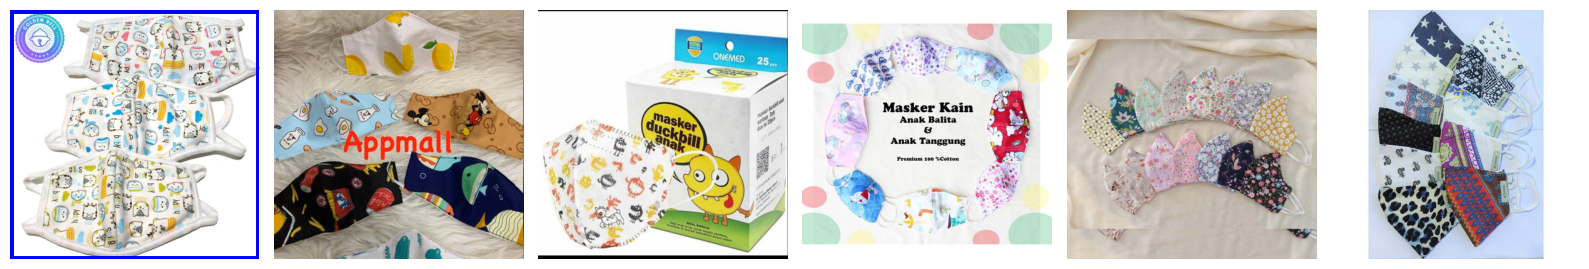

In [ ]:
plot_from_index(train_data, indexes[1099][:6])

# Inference on unseen data

In [ ]:
found_groups = df_train['label_group'].values[indexes]

test_data = pd.read_csv('/content/drive/MyDrive/COSE474/PROJECT/data/test.csv')
test_images_path = Path('/content/drive/MyDrive/COSE474/PROJECT/data/test_images')

In [ ]:
# Find similar matches
unseen_similarities, unseen_indexes = find_similarities_and_indexes(test_data, test_images_path)

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


In [ ]:
def plot_from_index_2(data, test_data, test_index, indices, titles=None):
    images = []
    for i, index in enumerate(indices):
        if i == 0:
            # 첫 번째 이미지는 다른 데이터에서 가져옴
            file_name = test_data.iloc[test_index]['image']
            path = f'/content/drive/MyDrive/COSE474/PROJECT/data/test_images/{file_name}'
        else:
            file_name = data.iloc[index]['image']
            path = f'product_images/{file_name}'
        img = Image.open(path)
        images.append(img.resize((400, 400)))

    # 이미지를 가로로 연속 출력
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))  # 한 행에 이미지를 나열

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')  # 이미지 축 제거

        if i == 0:  # 첫 번째 이미지에 테두리 추가
            img_width, img_height = img.size
            rect = plt.Rectangle(((img_width - 400) // 2, (img_height - 400) // 2), 400, 400, linewidth=5, edgecolor='blue', facecolor='none')  # 테두리 설정
            axes[i].add_patch(rect)  # 이미지에 테두리 추가

    plt.tight_layout()
    plt.show()


In [ ]:
features

In [ ]:
import faiss

# 임베딩 벡터들을 모은 전체 데이터 행렬 (예시로 각 이미지들의 임베딩 벡터를 담고 있는 변수들)
features1 = ...  # 첫 번째 이미지에 대한 임베딩 벡터들
features2 = ...  # 두 번째 이미지에 대한 임베딩 벡터들
features3 = ...  # 세 번째 이미지에 대한 임베딩 벡터들

# Faiss 인덱스 생성
embed_dim = 512  # 임베딩 벡터의 차원
index = faiss.IndexFlatIP(embed_dim)
index.add(features)  # 첫 번째 이미지의 임베딩 벡터들을 인덱스에 추가

# 첫 번째 이미지와 유사한 이웃 검색 (예시로 top_n을 5로 설정)
top_n = 5
distances1, indices1 = index.search(features1, top_n)  # 두 번째 이미지에 대해 첫 번째 이미지와의 유사도 검색
distances2, indices2 = index.search(features2, top_n)  # 세 번째 이미지에 대해 첫 번째 이미지와의 유사도 검색

# distances1, distances2는 두 번째, 세 번째 이미지의 각각 첫 번째 이미지와의 거리를 나타내는 배열
# indices1, indices2는 두 번째, 세 번째 이미지의 각각 첫 번째 이미지와 가장 유사한 이웃의 인덱스를 나타내는 배열


In [ ]:
%ls drive/MyDrive/COSE474/PROJECT

 clip_model.pt                            inference.ipynb
 CLIPmodel.pt                             load_dataset.ipynb
 CLIP-shopee.ipynb                        model.pt
'Copy of  shopee_train_CLIP.ipynb'       ' shopee_train_CLIP.ipynb'
'Copy of  shopee_train_CLIP_last.ipynb'   Supervised-Contrastive-Learning.ipynb
 data/                                    Untitled0.ipynb
 EfficientNet_demo.ipynb                  Untitled1.ipynb


In [ ]:
saved_features.shape

(34250, 1024)

In [ ]:
# Allocate memory for features
features_test = np.empty((3, 2*embed_dim), dtype=np.float32)

images_path = Path('/content/drive/MyDrive/COSE474/PROJECT/data/test_images')
ds = MyDataset(test_data, images_path)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=2)

# Begin predict
i = 0
for images, texts, _ in tqdm(dl):
    n = len(images)
    with torch.no_grad():
        # Generate image and text features
        images_features = model.encode_image(images.to(device))
        texts_features = model.encode_text(texts.to(device))

    # Concat features (first images then texts)
    features_test[i:i+n, :embed_dim] = images_features.cpu()
    features_test[i:i+n, embed_dim:] = texts_features.cpu()

    i += n


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


In [ ]:
embed_dim = 512

index = faiss.IndexFlatIP(2*embed_dim)
index.add(saved_features)


s, i = index.search(features_test, 6)

In [ ]:
i[0]

array([[23859, 23858,  7063, 25747, 23856, 27062],
       [ 8565, 11633, 12235, 32774,  8737,  4589],
       [20232, 23980, 26469, 20450, 33889, 11967]])

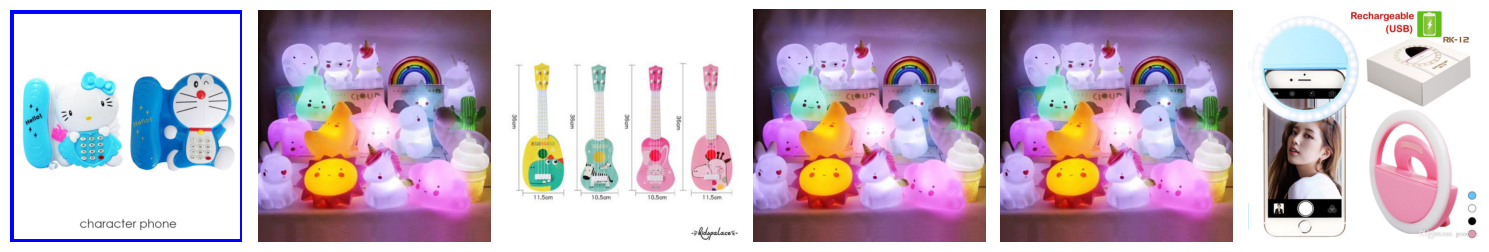

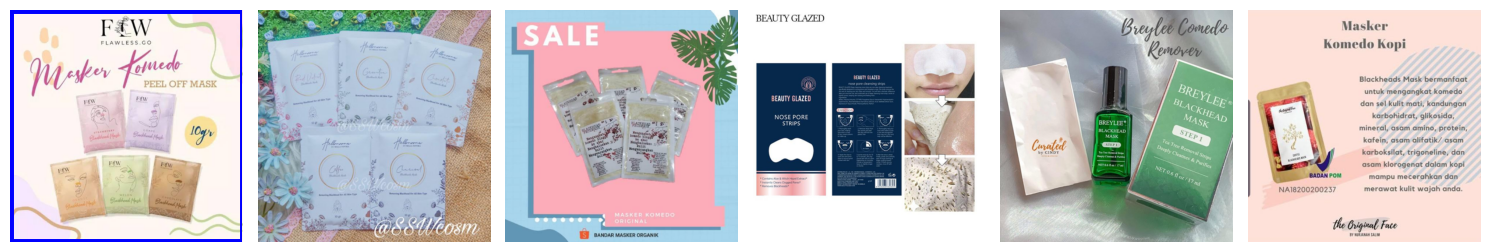

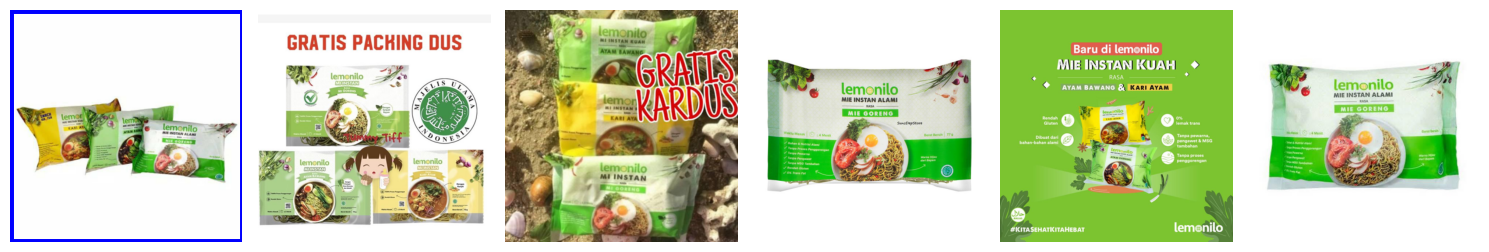

In [ ]:
plot_from_index_2(train_data, test_data, 0, i[0][:6])
plot_from_index_2(train_data, test_data, 1, i[1][:6])
plot_from_index_2(train_data, test_data, 2, i[2][:6])